In [3]:
import os
import xml.etree.ElementTree as ET
from lxml import etree
from PIL import Image, ImageDraw
import numpy as np
from sklearn.cluster import KMeans
import random
from sklearn.model_selection import train_test_split
import shutil
import csv
import pandas as pd
from tqdm.auto import tqdm


In [132]:
%%time

!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -U pycocotools
!pip install -qr yolov5/requirements.txt  # install dependencies
!cp yolov5/requirements.txt ./

fatal: destination path 'yolov5' already exists and is not an empty directory.
CPU times: user 17.9 ms, sys: 36 ms, total: 53.9 ms
Wall time: 2.42 s


In [4]:
# 資料夾路徑
labeled_folder = "/Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/Labeled"
source_folder = "/Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/source"
train_folder = "/Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/train"
val_folder = "/Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/validation"
cfg_folder = "/Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/cfg"

images_folder = "/Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/yolov5/images"
labels_folder = "/Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/yolov5/labels"

csv_file_path = "/Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/annotations.csv"


# 建立用於訓練和驗證的資料清單
train_data = []
val_data = []

# 解析 XML 檔案並提取腫瘤區域的邊界框
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    tumor_regions = []
    
    for obj in root.findall("object"):
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)
        tumor_regions.append((xmin, ymin, xmax, ymax))
    
    return tumor_regions

# 將資料轉換為 YOLO 格式的標記
def convert_to_yolo_format(image_width, image_height, xmin, ymin, xmax, ymax):
    # 計算中心點座標、寬度和高度
    x_center = (xmin + xmax) / 2.0
    y_center = (ymin + ymax) / 2.0
    width = xmax - xmin
    height = ymax - ymin
    
    # 將座標和尺寸轉換為相對比例
    x_center /= image_width
    y_center /= image_height
    width /= image_width
    height /= image_height
    
    return x_center, y_center, width, height

# 遍歷資料夾並處理資料
with open(csv_file_path, mode='w', newline='') as csv_file:
    fieldnames = ['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'x_center', 'y_center', 'width', 'height', 'classes']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for labeled_subfolder in os.listdir(labeled_folder):
        labeled_subfolder_path = os.path.join(labeled_folder, labeled_subfolder)
        source_subfolder_path = os.path.join(source_folder, labeled_subfolder)

        if os.path.isdir(labeled_subfolder_path) and os.path.isdir(source_subfolder_path):
            for xml_file in os.listdir(labeled_subfolder_path):
                if xml_file.startswith("ImageName_ai") and xml_file.endswith(".xml"):
                    xml_path = os.path.join(labeled_subfolder_path, xml_file)
                    image_name = xml_file.replace(".xml", ".jpg")
                    image_path = os.path.join(labeled_subfolder_path, image_name)

                    if os.path.exists(image_path) and os.path.exists(xml_path):
                        tumor_regions = parse_xml(xml_path)

                        # 在原始圖片上標記腫瘤區域
                        image = Image.open(image_path)
                        image_width, image_height = image.size

                        # 將標記轉換為 YOLO 格式
                        yolo_labels = []
                        for xmin, ymin, xmax, ymax in tumor_regions:
                            x_center, y_center, width, height = convert_to_yolo_format(image_width, image_height, xmin, ymin, xmax, ymax)
                            yolo_labels.append(f"0 {x_center} {y_center} {width} {height}")  # 假設類別編號為0（癌細胞）
                            # 寫入 CSV 檔案
                            writer.writerow({
                                'filename': image_name,
                                'xmin': xmin,
                                'ymin': ymin,
                                'xmax': xmax,
                                'ymax': ymax,
                                'x_center': x_center,
                                'y_center': y_center,
                                'width': width,
                                'height': height,
                                'classes': 0
                            })

                        # 將 YOLO 標記寫入檔案
                        yolo_label_file_path = os.path.join(labeled_subfolder_path, image_name.replace(".jpg", ".txt"))
                        with open(yolo_label_file_path, "w") as f:
                            f.write("\n".join(yolo_labels))

                        image_path_40x = os.path.join(labeled_subfolder_path, "40x_"+image_name)
                        image_40x = Image.open(image_path_40x)
                        draw = ImageDraw.Draw(image)
                        for xmin, ymin, xmax, ymax in tumor_regions:
                            draw.rectangle([xmin, ymin, xmax, ymax], outline="red")

                        # 使用訓練-驗證分割函數分配資料
                        if random.random() < 0.8:  # 80% 的資料用於訓練
                            train_data.append((image_path, yolo_label_file_path))
                        else:
                            val_data.append((image_path, yolo_label_file_path))

                    else:
                        print(f"Missing image or XML for {xml_file}")

In [2]:
# 創建訓練數據集和驗證數據集的文件夾
os.makedirs(images_folder, exist_ok=True)
os.makedirs(images_folder+"/train", exist_ok=True)
os.makedirs(images_folder+"/val", exist_ok=True)


os.makedirs(labels_folder, exist_ok=True)
os.makedirs(labels_folder+"/train", exist_ok=True)
os.makedirs(labels_folder+"/val", exist_ok=True)



# 將資料複製到訓練數據集和驗證數據集中
for data, data_folder in [(train_data, images_folder+"/train"), (val_data, images_folder+"/val")]:
    for image_path, xml_path in data:
        image_name = os.path.basename(image_path)
        xml_name = os.path.basename(xml_path)
                
        # 複製圖片
        new_image_path = os.path.join(data_folder, image_name)
        train_txt_path = os.path.join(data_folder, "train.txt")
        test_txt_path = os.path.join(data_folder, "test.txt")
        shutil.copy(image_path, new_image_path)
        
        # 將圖片路徑寫入對應的 train.txt 或 test.txt
        if "train" in data_folder:
            with open(train_txt_path, "a") as train_file:
                train_file.write(new_image_path + "\n")
#                 train_file.write(new_image_path.replace("jpg","xml") + "\n")
        elif "val" in data_folder:
            with open(test_txt_path, "a") as val_file:
                val_file.write(new_image_path + "\n") 
#                 val_file.write(new_image_path.replace("jpg","xml") + "\n")


# 將資料複製到訓練數據集和驗證數據集中
for data, data_folder in [(train_data, labels_folder+"/train"), (val_data, labels_folder+"/val")]:
    for image_path, xml_path in data:
        image_name = os.path.basename(image_path)
        xml_name = os.path.basename(xml_path)
                     
        # 複製 XML 檔案
        new_xml_path = os.path.join(data_folder, xml_name)
        shutil.copy(xml_path, new_xml_path)

NameError: name 'os' is not defined

# 開始設定YOLO模型

In [28]:
img_h, img_w, num_channels = (380, 676, 3)
df = pd.read_csv('/Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/annotations.csv')
df.rename(columns={'filename':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h
df.head()

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,width,height,classes,w,h
0,ImageName_ai_s_MdlxN5WQJy75wy2,458,483,566,542,0.757396,1.348684,0.105572,0.057674,0,0.159763,0.155263
1,ImageName_ai_s_0TMF7tkCfIPIlUN,457,481,567,543,0.757396,1.347368,0.107527,0.060606,0,0.162722,0.163158
2,ImageName_ai_s_pEpDX8l9MiwuXVd,474,467,550,557,0.757396,1.347368,0.074219,0.087891,0,0.112426,0.236842
3,ImageName_ai_s_VlmyO7SWv4hCQNE,482,474,542,550,0.757396,1.347368,0.058594,0.074219,0,0.088757,0.200000
4,ImageName_ai_s_FLSrzKvDLHpjG9N,466,449,558,575,0.757396,1.347368,0.089844,0.123047,0,0.136095,0.331579


In [32]:
%cd /Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/yolov5
!python train.py --img 1024 --batch 20 --epochs 10 --data './cell.yaml' --cfg ./models/custom_yolov5s_blog.yaml --weights ''

/Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/yolov5
train: weights=, cfg=./models/custom_yolov5s_blog.yaml, data=./cell.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=20, imgsz=1024, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-210-gdd10481 Python-3.10.6 torch-2.0.1 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.

        7/9         0G     0.1052    0.04486          0         20       1024: 1
                 Class     Images  Instances          P          R      mAP50   WARNING ⚠️ NMS time limit 2.200s exceeded
                 Class     Images  Instances          P          R      mAP50   
                   all         34         34          0          0          0          0

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
        8/9         0G     0.1055    0.04494          0         21       1024: 1
                 Class     Images  Instances          P          R      mAP50   WARNING ⚠️ NMS time limit 2.200s exceeded
                 Class     Images  Instances          P          R      mAP50   
                   all         34         34          0          0          0          0

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
        9/9         0G     0.1046    0.04374          0         18       1024: 1
               

In [37]:
%cd /Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/yolov5
!python detect.py --img 1024 --data './cell.yaml'  --weights ./runs/train/exp5/weights/best.pt --source /Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/yolov5/images/train --conf 0.25

/Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/yolov5
detect: weights=['./runs/train/exp5/weights/best.pt'], source=/Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/yolov5/images/train, data=./cell.yaml, imgsz=[1024, 1024], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-210-gdd10481 Python-3.10.6 torch-2.0.1 CPU

Fusing layers... 
custom_YOLOv5s_blog summary: 182 layers, 7246518 parameters, 0 gradients
image 1/114 /Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/yolov5/images/train/ImageName_ai_s_0A5LCZtt6gLKnHr.jpg: 1024x1024 (no detections), 335.4ms
image 2/114 /Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/yolov5/images/train/ImageName_ai_s_0UjSqPRa7WnTkrS.jpg: 1024x1024 (no detections), 322.3ms
image 3/114 

image 54/114 /Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/yolov5/images/train/ImageName_ai_s_U71r0gjoNFB7zYy.jpg: 1024x1024 (no detections), 320.7ms
image 55/114 /Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/yolov5/images/train/ImageName_ai_s_U8k51wkDUqZzs6m.jpg: 1024x1024 (no detections), 321.9ms
image 56/114 /Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/yolov5/images/train/ImageName_ai_s_URg9tP6pNi9wn6r.jpg: 1024x1024 (no detections), 323.2ms
image 57/114 /Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/yolov5/images/train/ImageName_ai_s_V5j41aGmtEgwZCq.jpg: 1024x1024 (no detections), 326.2ms
image 58/114 /Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/yolov5/images/train/ImageName_ai_s_WofgvxGsaAWWi7U.jpg: 1024x1024 (no detections), 321.7ms
image 59/114 /Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/yolov5/images/train/ImageName_ai_s_XbDO9c7bESA0NeE.jpg: 1024x1024 (no detections), 325.0ms
image 60/114 /Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/yolov5/images/train/ImageName_ai_s_Y61ssXu1nB4RzPL.jpg: 1024x1024 (no detections), 340.2ms
image 

image 112/114 /Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/yolov5/images/train/ImageName_ai_s_yDEw7BOOmb3ZCJ5.jpg: 1024x1024 (no detections), 326.7ms
image 113/114 /Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/yolov5/images/train/ImageName_ai_s_yjLTAKcG26iK0Ck.jpg: 1024x1024 (no detections), 327.2ms
image 114/114 /Users/yangzhelun/Desktop/尿液細胞切片癌細胞標記/yolov5/images/train/ImageName_ai_s_z4CoXG9epVOAPJA.jpg: 1024x1024 (no detections), 319.6ms
Speed: 1.1ms pre-process, 330.8ms inference, 0.5ms NMS per image at shape (1, 3, 1024, 1024)
Results saved to runs/detect/exp


ValueError: Could not save to JPEG for display

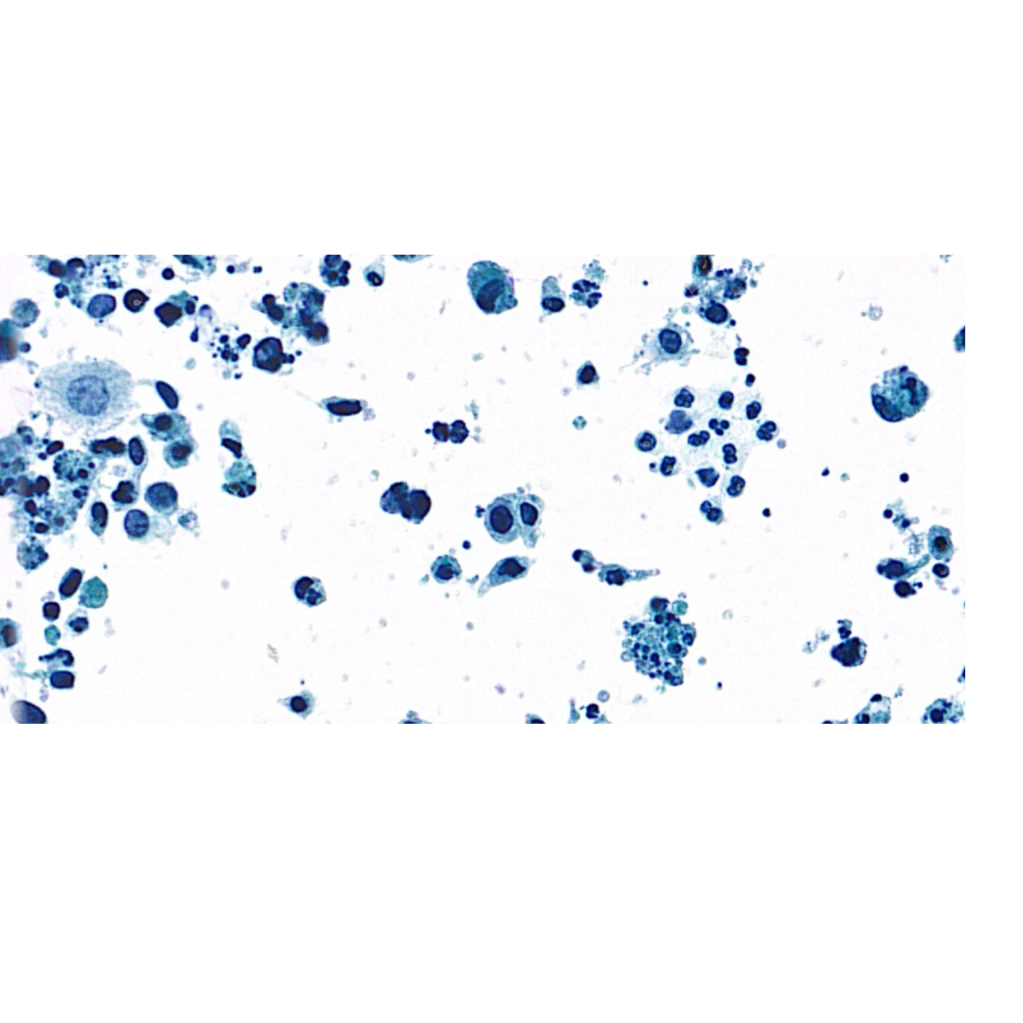